# SPAtial EFficiency metric
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __24/01/2020__

__Introducción__<br>
Se genera el código para aplicar la métrica de rendimiento de un modelo hidrólogico SPAEF [(Koch et al., 2018)](https://www.geosci-model-dev.net/11/1873/2018/). Es una función objetivo que analiza espacialmente el rendimiento del modelo y que emula la lógica detrás del criterio KGE (Kling-Gupta efficiency) [(Gupta et al., 2009)](https://www.sciencedirect.com/science/article/pii/S0022169409004843), utilizado habitualmente para el caudal.

$$SPAEF=1-\sqrt{(\alpha-1)^2+(\beta-1)^2+(\gamma-1)^2}$$
Donde $\alpha$ es el coeficiente de correlación de Pearson, $\beta$ el cociente entre los coeficientes de variación (representativo de la variabilidad espacial), y $\gamma$ es la intersección entre los histogramas normalizados del patrón observado ($K$) y del patrón simulado ($L$):
$$\alpha=\rho(obs,sim)
\;,\;\;
\beta=\frac{\frac{\sigma_{sim}}{\mu_{sim}}}{\frac{\sigma_{obs}}{\mu_{obs}}}
\;,\;\;
\gamma=\frac{\sum_{j=1}^{n}min(K_j,L_j)}{\sum_{j=1}^{n}K_j}$$

Como caso de estudio al que aplicar el código se utilizan los resultados de la simulación de la evapotranspiración en la cuenca alta del río Deva.

<font color='indianred'>__Limitación__: compara el acuerdo entre dos mapas, no entre dos series de mapas. Es decir, hay que obtener un mapa medio representativo de la variable. </font>

__Cosas que arreglar__ <br>
*  No se puede guardar el netCDF diario de TETIS en GitHub
*  Se genera un mapa de menos en la serie mensual de TETIS y eso genera error al calcular el rendimiento.

***

__Índice__ <br>
__[0 Configuración](#0-Configuración)__<br>

__[1 Sesgo](#1-Sesgo)__<br>
[1.1 Resultados SCEUA](#1.1-Resultados-SCEUA)<br>

In [1]:
import numpy as np
import pandas as pd

import calendar
from datetime import datetime, timedelta
from netCDF4 import Dataset
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'
print(rutaBase)

F:/Codigo/GitHub/Calibrar/docs/


In [2]:
%run funciones_rendimiento_espacial.ipynb

In [3]:
os.chdir(rutaBase + '../../MODIS/src/')
from funciones_MODIS import *
os.chdir(rutaBase)

In [4]:
os.chdir(rutaBase + '..')
from read_write import read_ascii, write_ascii

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set()
custom_style = {'axes.facecolor': 'k',
                'axes.edgecolor': 'gray',
                'axes.labelcolor': 'white',
                'figure.facecolor': 'k',
                'grid.color': 'gray',
                'text.color': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                "xtick.major.size": 0,
                "ytick.major.size": 0}
sns.set_style(style='darkgrid', rc=custom_style)

In [6]:
del animate3Darray

In [7]:
def animate3Darray(data, dates, minmax, cblabel='', fps=2, dpi=100, pathfile=None):
    """Crea una animación a partir de un 'array' 3D.
    
    Parámetros:
    -----------
    data:      array (tiempo, y, x)
    dates:     list (tiempo). Fechas a las que corresponden cada uno de los mapas de 'data'
    minmax:    list. Mínimo y máximo de la escala de colores
    cblabel:   string. Etiqueta de la escala de colores
    fps:       int. Imágenes por segundo
    dpi:       int. Resolución en puntos por pulgada
    pathfile:  string. Ruta, nombre y extensión donde guardar la animación. Por defecto es 'None y no se guarda
    """
    
    # definir configuración del gráfico en blanco
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(np.zeros(data1.shape[1:]), animated=True,
                   cmap='summer_r', vmin=minmax[0], vmax=minmax[1])
    plt.axis('off')
    cb = plt.colorbar(im, shrink=.7)
    cb.set_label(cblabel, fontsize=12)
    title = ax.text(.5, 1.05, '', fontsize=13, fontweight='bold',
                    transform=ax.transAxes, horizontalalignment='center')

    def updatefig(i, *args):
        """Función que define los datos a mostrar en el título en cada iteración"""
        title.set_text(dates[i])
        im.set_array(data[i,:,:])
        return im,

    # genera la animación iterando sobre 'updatefig' un número 'frames' de veces
    ani = animation.FuncAnimation(fig, updatefig, frames=data.shape[0], interval=1000/fps,
                                      blit=True)
        
    # guardar vídeo
    if pathfile is not None:
        ani.save(pathfile, fps=fps, extra_args=['-vcodec', 'libx264'], dpi=dpi)
    # plt.show()

    # ver vídeo en el 'notebook'
    return HTML(ani.to_html5_video())

***
## Configuración

In [8]:
var = 'ET'

In [9]:
rutaExport = rutaBase + '../output/'

***
## Cargar datos
#### MODIS

In [10]:
# fijar ruta y nombre del archivo
rutaMODIS = rutaBase + '../../MODIS/output/' + var + '/'
filename = 'MODIS_' + var + '_ArcGIS.nc'

In [11]:
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaMODIS + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
Data = {}
for sat in ['Terra', 'Aqua']:
    Data[sat] = {}
    # evapotranspiración
    Data[sat][var] = ncRead[sat][var][::].data
    # fechas
    Data[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    Data[sat]['X'] = ncRead[sat]['X'][:].data
    Data[sat]['Y'] = ncRead[sat]['Y'][:].data

ncRead.close()

In [12]:
print('Terra:\t{0}'.format(Data['Terra'][var].shape))
print('Aqua:\t{0}'.format(Data['Aqua'][var].shape))

Terra:	(840, 46, 47)
Aqua:	(774, 46, 47)


Voy a utilizar los datos de __Terra__ porque comienzan antes y, por tanto, tienen mayor solape con el periodo de simulación en TETIS.

In [13]:
del Data['Aqua']

#### TETIS

In [14]:
# fijar rutas y nombre del archivo
rutaData = rutaBase + '../data/'
filename = 'TETIS_' + var + '.nc'

In [15]:
if os.path.exists(rutaData + filename) == False:

    # IMPORTAR ASCII DE TETIS
    # -----------------------
    # ruta del proyecto TETIS
    rutaTETIS = 'F:/Proyectos/GESDIVAH/SDM/TETIS/PdE/Actual/Bias/'

    # lista de archivos con los resultados
    os.chdir(rutaTETIS + '_ASCII/')
    files = [file for file in os.listdir() if file[-3:] == 'asc']

    # cargar archivos ascii con los resultados de TETIS
    for i, file in enumerate(files):
        print('archivo {0:>3} de {1}: {2}'.format(i+1, len(files), file), end='\r')
        # leer archivo ascii
        read_ascii(file)
        if i == 0:
            Datatetis = read_ascii.data
            atrsTetis = read_ascii.attributes
        else:
            Datatetis = np.dstack((Datatetis, read_ascii.data))    

    # transformar 'Datatetis' para que la primera dimensión sea el tiempo
    Datatetis = np.moveaxis(Datatetis, 2, 0)
    
    # guardar en un diccionario
    TETISdict = {}
    TETISdict[var] = Datatetis
    del Datatetis

    # fechas de cada mapa
    datesStr = [file.split('_')[1].split('.')[0][:8] for file in files]
    dates = np.array([datetime(int(date[:4]), int(date[4:6]), int(date[6:8])).date() for date in datesStr])
    At = int(np.mean([d.days for d in np.diff(dates)]))
    dates = dates - timedelta(At) # mover fecha al inicio del periodo correspondiente
    TETISdict['dates'] = dates
    del datesStr, dates

    # coordenadas
    TETISdict['X'] = np.arange(atrsTetis[2], atrsTetis[2] + atrsTetis[0] * atrsTetis[4],
                                 atrsTetis[4])
    TETISdict['Y'] = np.arange(atrsTetis[3], atrsTetis[3] + atrsTetis[1] * atrsTetis[4],
                                 atrsTetis[4])

    # GENERAR NETCDF
    # --------------
    # definir el netcdf
    if os.path.exists(rutaBase + '../data/') == False:
        os.makedirs(rutaBase + '../data/') # crear carpeta donde guardarlo
    ncTETIS = Dataset(rutaData + filename, 'w', format='NETCDF4')

    # crear atributos
    ncTETIS.description = 'Serie temporal de mapas de evapotranspiración simulados con TETIS de la cuenca del Deva'
    ncTETIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
    ncTETIS.coordinateSystem = 'epsg:25830' # ETRS89 30N

    # crear las dimensiones
    time = ncTETIS.createDimension('time', len(TETISdict['dates']))
    Y = ncTETIS.createDimension('Y', len(TETISdict['Y']))
    X = ncTETIS.createDimension('X', len(TETISdict['X']))

    # crear variables
    data = ncTETIS.createVariable(var, 'f4', ('time', 'Y', 'X'))
    data.units = 'mm/8días'
    times = ncTETIS.createVariable('time', 'f8', ('time',))
    times.units = 'días desde el 0001-01-01'
    times.calendar = 'Gregoriano'
    Xs = ncTETIS.createVariable('X', 'u4', ('X',))
    Xs.units = 'm'
    Ys = ncTETIS.createVariable('Y', 'u4', ('Y',))
    Ys.units = 'm'

    # variable
    data[:,:,:] = TETISdict[var][:,:,:]
    # variable 'time'
    deltas = [date - datetime(1, 1, 1).date() for date in TETISdict['dates']]
    times[:] = [delta.days for delta in deltas]
    # variable 'X'
    Xs[:] = TETISdict['X']
    # variable 'Y'
    Ys[:] = TETISdict['Y']

    ncTETIS.close()

In [16]:
# IMPORTAR NETCDF
# ---------------
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaData + filename, 'r', format='NETCDF4')
# extraer datos en un diccionario
Data['TETIS'] = {}
# evapotranspiración
Data['TETIS'][var] = ncRead[var][::].data
# fechas
Data['TETIS']['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead['time'][:]]
# coordenadas
Data['TETIS']['X'] = ncRead['X'][:].data.astype('int')
Data['TETIS']['Y'] = ncRead['Y'][:].data.astype('int')
# cerrar conexión
ncRead.close()

print('TETIS:\t{0}'.format(Data['TETIS'][var].shape))

TETIS:	(3653, 216, 222)


In [ ]:
# video of TETIS's daily data
animate3Darray(Data['TETIS'][var], Data['TETIS']['dates'], minmax=[0, 16],
               cblabel=var + ' (mm)', fps=8, pathfile=rutaExport + 'ET-TETIS_1d_100m.mp4')

### Seleccionar periodo de estudio
Se seleccionan los datos correspondientes al periodo en el que ambas fuentes (Terra y TETIS) tienen datos.

In [17]:
dateMin = max(Data['Terra']['dates'][0], Data['TETIS']['dates'][0]).date()
dateMax = min(Data['Terra']['dates'][-1], Data['TETIS']['dates'][-1]).date()
print('fecha de inicio:\t{0}\nfecha de fin:\t\t{1}'.format(dateMin, dateMax))

fecha de inicio:	2001-01-01
fecha de fin:		2004-09-30


In [18]:
# recortar datos a las fechas de inicio y fin
for src in ['Terra', 'TETIS']:
    print(src)
    # seleccionar datos de Terra dentro de las fechas de inicio y fin
    datesSrc = np.array([d.date() for d in Data[src]['dates']])
    mask = (datesSrc >= dateMin) & (datesSrc <= dateMax)
    Data[src]['dates'] = datesSrc[mask]
    print('nº de fechas:\t{0}'.format(len(Data[src]['dates'])))

    # recortar los mapas dentro de las fechas de inicio y fin
    Data[src][var] = Data[src][var][mask, :, :]
    print('dimensiones:\t{0}'.format(Data[src][var].shape))

    del datesSrc, mask
    print()

Terra
nº de fechas:	172
dimensiones:	(172, 46, 47)

TETIS
nº de fechas:	1369
dimensiones:	(1369, 216, 222)



### Unificar resolución de los mapas
<font color='indianred'>¿Es mejor aumentar la resolución de MODIS o reducir la de TETIS?</font><br>
Genero una nueva fuente (primera 'key' del diccionario) en la que guardar los resultados de TETIS remuestreados para concordar con la resolución de los mapas de MODIS.

In [19]:
# resolución de MODIS
resMODIS = 463.3127165275

In [20]:
Data['TETIS_'] = {}
t = Data['TETIS'][var].shape[0]
n, m = Data['Terra'][var].shape[1], Data['Terra'][var].shape[2]
Data['TETIS_'][var] = np.ones((t, n, m)) * np.nan

# hacer la media sobre una ventana móvil de 5x5 celdas
for i, y in enumerate(Data['Terra']['Y']):
    for j, x in enumerate(Data['Terra']['X']):
        maskY = np.where(abs(Data['TETIS']['Y'] - y) < resMODIS / 2)[0]
        maskX = np.where(abs(Data['TETIS']['X'] - x) < resMODIS / 2)[0]
#         print('i: {0}\tj: {1}\tdimensiones de la máscara: ({2},{3})'.format(i, j, len(maskY),
#                                                                             len(maskX)), end='\r')
        Data['TETIS_'][var][:,i,j] = np.nanmean(Data['TETIS'][var][:,maskY,:][:,:,maskX], axis=(1,2))

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [21]:
# guardar resto de variables
Data['TETIS_']['dates'] = Data['TETIS']['dates']
Data['TETIS_']['X'] = Data['Terra']['X']
Data['TETIS_']['Y'] = Data['Terra']['Y']

In [22]:
for src in ['Terra', 'TETIS_']:
    print(src)
    print('dimensiones:\t{0}'.format(Data[src][var].shape))

Terra
dimensiones:	(172, 46, 47)
TETIS_
dimensiones:	(1369, 46, 47)


***
## Análisis
1. <font color='steelblue'>Generar mapas medios</font>. Probaría inicialmente con un mapa medio de junio, al igual que hace Koch (2018). Aunque el número de mapas de las dos fuentes es el mismo, las fechas no coinciden, con lo que no es posible comparar mapa contra mapa.
2. <font color='steelblue'>Normalizar mapas</font>. Necesario para comparar dos mapas que puedan tener diferentes magnitudes
3. <font color='steelblue'>Analizar SPAEF</font>

### Serie 8 diaria
#### Generar serie

In [23]:
# calcular serie 8-diaria de TETIS
Data['TETIS8d'] = {}
Data['TETIS8d'][var] = np.ones((Data['Terra'][var].shape)) * np.nan
Data['TETIS8d']['dates'] = []
w = 8 # ventanda
for i, date in enumerate(Data['TETIS_']['dates'][::w]):
    print(date, end='\r')
    j = (date - dateMin).days
    if (date + timedelta(w)).year > date.year:
        w_ = (datetime(date.year + 1, 1, 1).date() - date).days
    else:
        w_ = w
    Data['TETIS8d'][var][i,:,:] = np.sum(Data['TETIS_'][var][j:j+w_,:,:], axis=0)
    Data['TETIS8d']['dates'].append(date)

Data['TETIS8d']['X'] = Data['Terra']['X']
Data['TETIS8d']['Y'] = Data['Terra']['Y']

In [24]:
for src in ['Terra', 'TETIS8d']:
    print(src)
    print('dimensiones:\t{0}'.format(Data[src][var].shape))

Terra
dimensiones:	(172, 46, 47)
TETIS8d
dimensiones:	(172, 46, 47)


#### Comparativa

C:\Anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


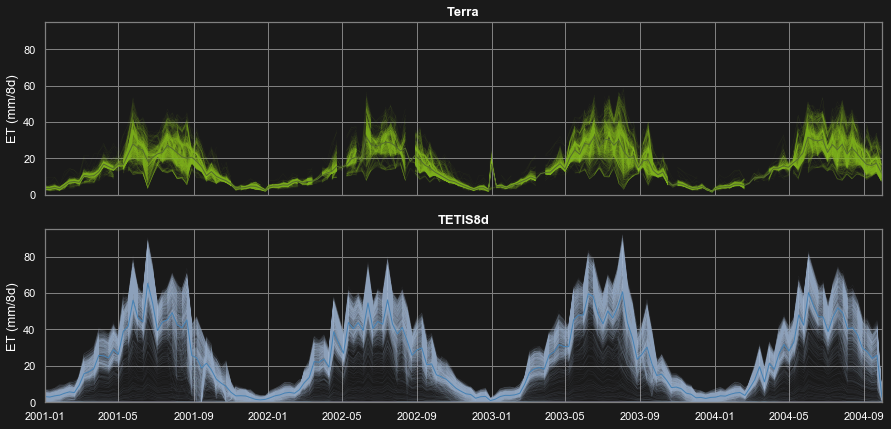

In [25]:
plotMODISseries(Data, var, 'dates', r=5, src=['Terra', 'TETIS8d'],
                ylabel=var + ' (mm/8d)')
plt.savefig(rutaExport + 'Comparativa series 8 diarias.png', dpi=300, tight_layout=True)

In [ ]:
# video of TETIS's 8-daily data
animate3Darray(Data['TETIS8d'][var], dates=Data['TETIS8d']['dates'],
               minmax=[0, 100], cblabel=var + ' (mm/8d)', fps=4,
               pathfile=rutaExport + 'ET-TETIS_8d_500m.mp4')

In [ ]:
# video datos MODIS-Terra (8 días)
animate3Darray(Data['Terra'][var], dates=Data['Terra']['dates'],
               minmax=[0, 100], cblabel=var + ' (mm/8d)', fps=4,
               pathfile=rutaExport + 'ET-Terra_8d_500m.mp4')

Los mapas originales de MODIS contienen numerosos huecos, lo que hace complicado la comparación con los mapas simulados con TETIS, en los que no hay huecos.

### Serie mensual

In [30]:
# generar series mensuales
for src in ['Terra', 'TETIS_']:
    print(src)
    Data[src]['serieM'], Data[src]['months'] = serieMensual(Data[src]['dates'],
                                                            Data[src][var], agg='sum')
    print()

Terra
celda  2162 de  2162
TETIS_
celda  2162 de  2162


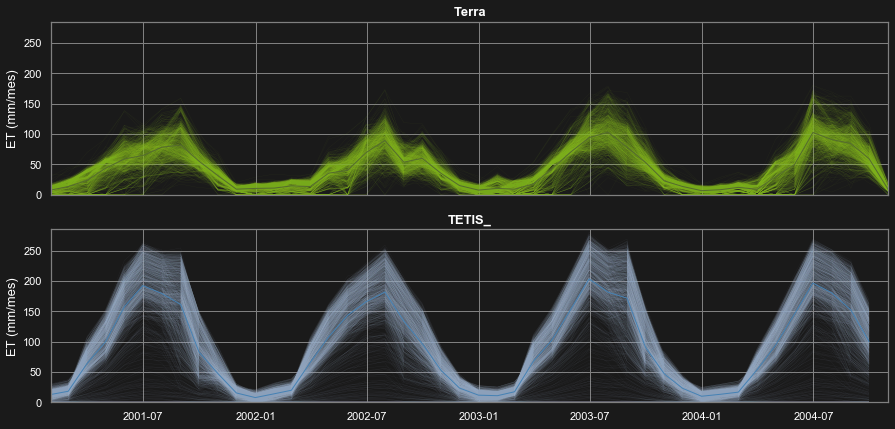

In [31]:
plotMODISseries(Data, 'serieM', 'months', r=5, src=['Terra', 'TETIS_'],
                ylabel=var + ' (mm/mes)')
plt.savefig(rutaExport + 'Comparativa series mensuales.png', dpi=300, tight_layout=True)

Se simula un exceso de evapotranspiración en verano y un ligero adelanto de la época de crecimiento vegetativo en la primavera.

### Medias mensuales

In [34]:
def mediaMensual(months, Data):
    """Calcula la media mensual interanual para cada mes del año
    
    Parámetros:
    -----------
    months:     array (t). Fecha correspondiente de cada uno de los mapas mensuales
    Data:      array (t,n,m). Datos la serie de mapas mensuales
    
    Ambos parámetros de entrada son las salidas de 'serieMensual'
    
    Salida:
    -------
    meanM:     array(12,n,m). Media mensual de la variable
    """
    
    # medias mensuales
    meanM = np.zeros((12, Data.shape[1], Data.shape[2])) * np.nan
    for m, month in enumerate(range(1, 13)):
        ks = [k for k, date in enumerate(months) if date.month == month]
        meanM[m,:,:] = np.nanmean(Data[ks,:,:], axis=0)
        
    return meanM

In [35]:
# generar medias mensuales
for src in ['Terra', 'TETIS_']:
    Data[src]['meanM'] = mediaMensual(Data[src]['months'], Data[src]['serieM'])

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


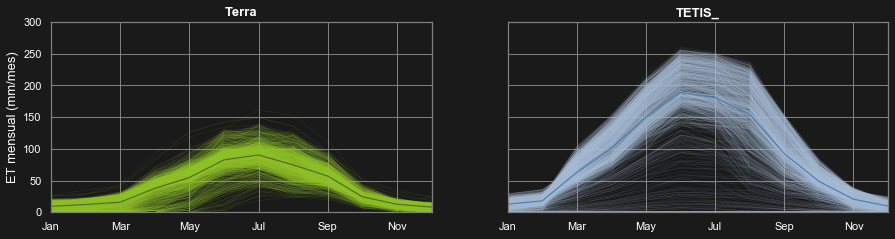

In [38]:
# mostrar la media mensual para cada celda y la media de la cuenca
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharey=True)

r = 50
ymax = np.ceil(max([np.nanmax(Data[src]['meanM']) for src in ['Terra', 'TETIS_']]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, src) in enumerate(zip(axes, ['Terra', 'TETIS_'])):
    meanMx = Data[src]['meanM']
    for i in range(meanMx.shape[1]):
        for j in range(meanMx.shape[2]):
            if np.isnan(meanMx[:,i,j]).sum() == meanMx.shape[0]: # celda vacía
                continue
            else:
                ax.plot(meanMx[:,i,j], lw=.25, c=colors[c][0], alpha=.25)
    ax.plot(np.nanmean(meanMx, axis=(1, 2)), c=colors[c][1], lw=1.2)
    ax.tick_params(labelsize=11)
    ax.set(xlim=(0, 11), ylim=(0, ymax))
    if c == 0:
        ax.set_ylabel(var + ' mensual (mm/mes)', fontsize=13);
    monthnames = [datetime(1900, m, 1).strftime('%b') for m in range(1, 13)]
    ax.set_xticklabels(monthnames[::2])
    ax.set_title(src, fontsize=13, fontweight='bold')
plt.savefig(rutaExport + 'Comparativa medias mensuales.png', dpi=300, tight_layout=True)

In [44]:
print('ETmedia (Terra):\t{0:.1f} mm'.format(np.nanmean(Data['Terra']['meanM']) *12))
print('ETmedia (TETIS):\t{0:.1f} mm'.format(np.nanmean(Data['TETIS_']['meanM']) * 12))

ETmedia (Terra):	480.7 mm
ETmedia (TETIS):	1041.2 mm


En la figura superior se comprueba claramente cómo la simulación sobrevalora la evapotranspiración. La evapotranspiración media de TETIS (1041.2 mm) la observada por MODIS (480 mm).

#### Mapa medio de junio

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.subplots_adjust(right=0.9)

r = 10
vmin = np.floor(np.nanmin([Data[src]['meanM'][7,:,:] for src in ['Terra', 'TETIS_']]) / r) * r
vmax = np.ceil(np.nanmax([Data[src]['meanM'][7,:,:] for src in ['Terra', 'TETIS_']]) / r) * r
cmap = 'summer_r'

for ax, src in zip(axes, ['Terra', 'TETIS_']):
    im = ax.imshow(Data[src]['meanM'][7,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(src, fontsize=13)
    ax.axis('off')
    
cbar_ax = fig.add_axes([0.925, 0.3, 0.01, 0.4])
cbar_ax.tick_params(labelsize=12)
cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
cb.set_label('mm/mes', fontsize=14)
    
fig.text(0.5, .92, 'ET media junio', fontsize=15, fontweight='bold', horizontalalignment='center');

### Rendimiento

In [72]:
def rend_espacial(dates, obs, sim):
    """Calcula el SPAEF y KGE espacial entre las matrices observadas y simuladas
    
    Parámetros:
    -----------
    dates:     array (t,). Lista de fechas a la que corresponden los mapas
    obs:       array (t,n,m). Mapas observados
    sim:       array (t,n,m). Mapas simulados
    
    Salida:
    -------
    rend:      dataframe (t,2). Valores del SPAEF y KGE para cada una de las fechas"""
    
    # comprobar que los datos de entrada son correctos
    if obs.shape != sim.shape:
        print('ERROR. No coinciden las dimensiones de la matriz observada y simulada')
    if len(dates) != obs.shape[0]:
        print('ERROR. No coincide la longitud de "dates" con la primera dimensión de las matrices')
    
    # calcular rendimiento
    rend = pd.DataFrame(index=dates, columns=['KGE', 'SPAEF'])
    for d, date in enumerate(dates):
        rend.loc[date, 'KGE'] = KGEsp(obs[d,:,:], sim[d,:,:])
        rend.loc[date, 'SPAEF'] = SPAEF(obs[d,:,:], sim[d,:,:])
    
    return rend

### Mapas 8-diarios

In [73]:
R8d = rend_espacial(Data['Terra']['dates'], Data['Terra'][var], Data['TETIS8d'][var])

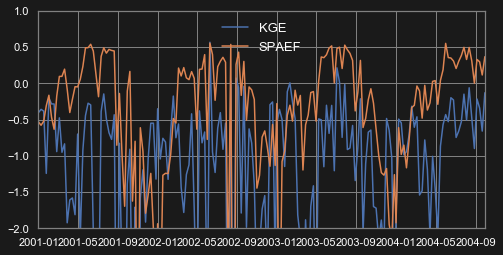

In [74]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(R8d.KGE, label='KGE')
ax.plot(R8d.SPAEF, label='SPAEF')
ax.set(xlim=(R8d.index[0], R8d.index[-1]), ylim=(-2, 1))
ax.legend(fontsize=13);

#### Mapas de medias mensuales

In [76]:
RmM = rend_espacial(calendar.month_abbr[1:], Data['Terra']['meanM'], Data['TETIS_']['meanM'])

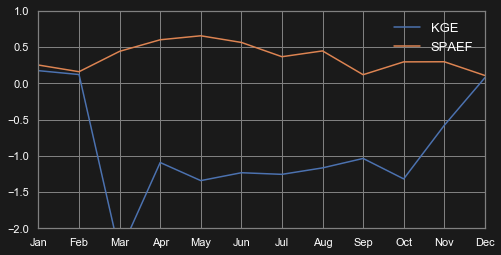

In [77]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(RmM.KGE, label='KGE')
ax.plot(RmM.SPAEF, label='SPAEF')
ax.set(xlim=(RmM.index[0], RmM.index[-1]), ylim=(-2, 1))
ax.legend(fontsize=13);

Se observa una mayor sensibilidad del SPAEF que del KGE. El SPAEF toma valores muy bajos en febrero y noviembre, y varlores relativamente buenos de junio a agosto. Por el contrario, el KGE tiene valores relativamente constantes entre -0.5 y 0 durante todo el año, aun también con valores ligeramente mejores en el verano.

#### Serie de mapas mensuales

In [81]:
Data['Terra']['months'].shape, Data['Terra']['serieM'].shape, Data['TETIS_']['serieM'].shape

((46,), (46, 46, 47), (45, 46, 47))

In [80]:
RsM = rend_espacial(Data['Terra']['months'], Data['Terra']['serieM'], Data['TETIS_']['serieM'])

ERROR. No coinciden las dimensiones de la matriz observada y simulada


IndexError: index 45 is out of bounds for axis 0 with size 45

In [48]:
# rendimiento medias mensuales
RsM = pd.DataFrame(index=Data['Terra']['months'], columns=['KGE', 'SPAEF'])

for m, month in enumerate(RsM.index):
    RsM.loc[month, 'KGE'] = KGEsp(obs=Data['Terra']['serieM'][m,:,:],
                                  sim=Data['TETIS_']['serieM'][m,:,:])
    RsM.loc[month, 'SPAEF'] = SPAEF(obs=Data['Terra']['serieM'][m,:,:],
                                    sim=Data['TETIS_']['serieM'][m,:,:])

IndexError: index 45 is out of bounds for axis 0 with size 45

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(RsM.KGE, label='KGE')
ax.plot(RsM.SPAEF, label='SPAEF')
ax.set(xlim=(RsM.index[0], RsM.index[-1]), ylim=(-2, 1))
ax.legend(fontsize=13);

Se comprueba el mismo comportamiento indicado para la media mensual. El SPAEF tiene una mayor variabilidad (rango de variación) que el KGE. Ambas métricas tienen un ciclo anual con mejor rendimiento en los veranos y peor rendimiento en los inviernos.

In [ ]:
fmt = '%Y-%m-%d'
s = '2012-10-09'
dt = datetime.strptime(s, fmt)
tt = dt.timetuple()
tt.tm_yday

#### Sesgo: $\rho$
El sesgo no está incluido en la definición de SPAEF de [(Koch et al., 2018)](https://www.geosci-model-dev.net/11/1873/2018/). En parte en ellos obvian el sesgo porque comparan dos variables relacionadas, pero con unidades distintas (calor latente y evapotranspiración).

En el caso de TETIS y MODIS, la variables y las unidades son las mismas: evapotranspiración en mm. Por tanto, es posible, y considero que conveniente, estimar el sesgo entre observación y simulación para asegurar un correcto balance hídrico.

Además, el sesgo nos permitirá calcular el KGE.

In [ ]:
S = np.nansum(aux_, axis=1)
rho = (S[1] - S[0]) / S[0]
print('rho = {0:.3f}'.format(rho))